# Sentiment in popular Danish news

When I read news, I sometimes suspect they may have a negative impact on my mood and general outlook. Therefore, I set out to analyze the sentiment on the most popular Danish media.

Based on my own developed webscraper using BeautifulSoup and Selenium, I have gathered approximately 1800 news articles from:  
- DR
- TV2
- Ekstrabladet
- BT

I use the Danish Sentida model to assess Sentiment in both news content and titles.  
Moreover, I use spaCy for Named Entity Recognition to explore, which entities receive the most negative and positive sentiment.  

I have mainly analyzed the results in Tableau, but a brief analysis can be found by the end of the notebook.   
In general, I find that the results on the news make sense, but additionally, I ran the sentiment model on a Mr. Bean play and H.C. Andersens "Den lille pige med svovlstikkerne" to get a baseline for corpora that I believed to be very positive and negative, respectively. The results did not turn out the way I expected, which may indicate a limitation of Sentida, especially when it comes to subtle comedy.

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from sentida import Sentida
import re
import string
from tqdm.notebook import tqdm_notebook
import datetime
import spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import numpy
import matplotlib.pyplot as plt

tqdm_notebook.pandas()
pd.set_option('max_colwidth', 600)

### Import data and prepare for analysis

In [2]:
# Import and collect all daily scraped files
csvPath = r"D:\news"

df_list = []

for f in glob.glob(csvPath + "\*.csv"):
        df = pd.read_csv(f)
        filename = (os.path.basename(f))
        df['Filename'] = filename

        df_list.append(df)

article_df = pd.concat(df_list, ignore_index=True)

# If not enough new daily articles, there will be duplicates
article_df.drop_duplicates(subset='link',inplace=True)

# LIVE links are not real articles and do not contain text
article_df = article_df[article_df['content'].str.len() > 1]

article_df.reset_index(inplace=True)
article_df = article_df.drop(['index'],axis=1)

In [3]:
article_df.head()

,link,title,content,medie,Filename
0,https://dr.dk//nyheder/seneste/filmstjernen-kevin-spacey-sigtet-fire-tilfaelde-af-seksuelle-overgreb,Filmstjernen Kevin Spacey sigtet for fire tilfælde af seksuelle overgreb,"4 min. sidenFilmstjernen Kevin Spacey sigtet for fire tilfælde af seksuelle overgrebSkuespilleren Kevin Spacey har fået en del anklager imod sig om seksuelle overgreb, og nu er han også blevet sigtet. (Foto: SOCIAL MEDIA © Ritzau Scanpix)Læs opOrdbogTekstAf Frederik PalleDen britiske anklagemyndighed, Crown Prosecution Service, har i dag sigtet filmstjernen Kevin Spacey for fire tilfælde af seksuelle overgreb. Det skriver BBC.De seksuelle overgreb skulle være sket mod tre mænd.Kevin Spacey har i et langt stykke tid ikke været en del af film eller tv-serier på grund af andre anklager om ove...",DR,articles_2022-05-26.csv
1,https://dr.dk//nyheder/seneste/kampe-i-den-ukrainske-region-donbas-er-paa-sit-hidtil-mest-voldsomme-niveau,Kampe i den ukrainske region Donbas er på sit hidtil mest voldsomme niveau,"24 min. sidenKampe i den ukrainske region Donbas er på sit hidtil mest voldsomme niveauLæs opOrdbogTekstAf Frederik PalleSituationen i Donbas-regionen i Ukraine er yderst anspændt lige nu. Det siger Ukraines viceforsvarsminister Ganna Malyar på et pressemøde torsdag ifølge AFP.Hun forklarer, at kampene lige nu er på sit hidtil voldsomste niveau.- Kampene har nået maksimal intensitet. Fjendtlige styrker stormer vores styrkers positioner samtidig fra forskellige retninger. Vi har et ekstremt svært og langt stadie af kampe foran os, siger hun.De russiske styrker har fokuseret på Donbas-region...",DR,articles_2022-05-26.csv
2,https://dr.dk//sporten/seneste-sport/franskmand-venter-holger-rune-i-french-open,Holger Rune får fransk modstand i French Open,"51 min. sidenHolger Rune får fransk modstand i French OpenHolger Rune møder franske Hugo Gaston, når danskeren skal spille sin kamp i tredje runde ved French Open. (Foto: Jean-Francois Badias © Associated Press)Læs opOrdbogTekstDer venter fransk modstand for Holger Rune, når det danske tennis-es skal i aktion i tredje runde ved grand slam-turneringen French Open.Torsdag - et par timer efter at Rune havde spillet sig videre - vandt Hugo Gaston over argentinske Pedro Gachin.Dermed står det klart, at Rune og Gaston tørner sammen i tredje runde. Franskmanden ligger aktuelt nummer 74 på verdens...",DR,articles_2022-05-26.csv
3,https://dr.dk//nyheder/seneste/vaccine-til-abekopper-tilbydes-uden-eu-godkendelse-overlaege-finder-det-forsvarligt,Vaccine til abekopper tilbydes uden EU-godkendelse - overlæge finder det forsvarligt,"I dag kl. 15:40Vaccine til abekopper tilbydes uden EU-godkendelse - overlæge finder det forsvarligtLæs opOrdbogTekstAf Frederik PalleI morgen ankommer der 200 doser af medicinvirksomheden Bavarian Nordics vaccine mod abekopper til Danmark. Den er ikke godkendt i EU.Overlæge og professor Thomas Benfield fra Infektionsmedicinsk Afdeling på Hvidovre Hospital mener dog, at det vil være forsvarligt at tilbyde vaccinen til nære kontakter af smittede.- Den er godkendt andre steder. Og formålet - at forhindre at nogle bliver syge - opvejer efter min mening, at den endnu ikke er godkendt, siger han...",DR,articles_2022-05-26.csv
4,https://dr.dk//nyheder/seneste/flere-testede-solcremer-indeholder-stoffer-mistaenkt-vaere-hormonforstyrrende,Flere testede solcremer indeholder stoffer mistænkt for at være hormonforstyrrende,"I dag kl. 15:12Flere testede solcremer indeholder stoffer mistænkt for at være hormonforstyrrendeLæs opOrdbogTekstAf Casper Lindbjerg GreveEn test fra Forbrugerrådet Tænk Kemi viser, at flere solcremer indeholder mere end blot beskyttelse mod solstrålerne.Ud af 35 testede solcremer og solspray med solfaktor 30 indeholdt en tredjedel af de testede solcremer stoffer, som mistænkes at være hormonforstyrrende.Solcremerne er ikke i sig selv farlige, men gravide må gerne tænke sig om, lyder det fra Anna-Maria Andersson, der er seniorforsker på Rigshospitalet.- So

In [4]:
article_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   link      1819 non-null   object
 1   title     1819 non-null   object
 2   content   1819 non-null   object
 3   medie     1819 non-null   object
 4   Filename  1819 non-null   object
dtypes: object(5)
memory usage: 71.2+ KB


In [5]:
def preprocess(sentence):
    sentence=str(sentence)
    
    # Lowercase (not used due to named entity recognition)
    #sentence = sentence.lower()
    
    # Cleaning
    # html
    sentence = sentence.replace('{html}'," ")
    # tags
    sentence = re.sub(r'<.*?>', ' ', sentence)
    # links
    sentence = re.sub(r'http\S+', ' ',sentence)
    # numbers
    sentence = re.sub('[0-9]+', ' ', sentence)
    # specific non-content
    sentence = re.sub(r'Læs opOrdbogTekstAf \w* [A-Z][a-z]*','',sentence)
    # newlines
    sentence = re.sub('\n',' ',sentence)
    
    return sentence

In [6]:
article_df['content_clean'] = article_df['content'].apply(preprocess)

In [7]:
# Find categories from link structure
article_df['categories_list'] = article_df['link'].str.split('/').apply(lambda x: list(filter(None,x[3:-1])))

In [8]:
article_df['category_1'] = article_df['categories_list'].str[0]
article_df['category_2'] = article_df['categories_list'].str[1]

### Sentiment analysis

In [9]:
# Sentida model
def get_sentiment(text):
    SV = Sentida()
    print(text[:60],end='\r')
    sentiment = SV.sentida(
            text = text,
            output = 'mean',
            normal = False,
            speed = 'normal')
    return sentiment

In [10]:
# Content sentiment
article_df['sentiment_content'] = article_df['content_clean'].progress_apply(lambda x: get_sentiment(x))

  0%|          | 0/1819 [00:00<?, ?it/s]

In [11]:
# Title sentiment
article_df['sentiment_title'] = article_df['title'].progress_apply(lambda x: get_sentiment(x))

  0%|          | 0/1819 [00:00<?, ?it/s]

### Named Entity Recognition

In [12]:
# Loading spacy model - medium
nlp = spacy.load('da_core_news_md')

In [13]:
# Find Named Entities
article_df['enti'] = article_df['content_clean'].progress_apply(lambda x: list(nlp(x).ents))

  0%|          | 0/1819 [00:00<?, ?it/s]

In [14]:
# Convert entities from list to string
article_df['enti_str'] = [','.join(map(str, l)) for l in article_df['enti']]

In [15]:
# Replace some special characters explicitly as these are not recognized as columns and my RegEx pattern unfortunately also removes æøå in the Danish language.
article_df['enti_str'] = article_df['enti_str'].str.replace("'", '',regex=False).str.replace(".", '',regex=False).str.replace("-", '',regex=False).str.replace('"', ' ',regex=False)

In [16]:
# Add Named Entities as columns
def create_ent_cols(df,enti_col):
    cv = CountVectorizer()
    results = cv.fit_transform(df[enti_col])
    features = cv.get_feature_names_out()
    enti_df = pd.DataFrame(results.toarray(),columns=features)
    art_df =  pd.concat([df.reset_index(drop=True),enti_df.reset_index(drop=True)],axis=1)
    # Remove duplicated columns
    return art_df.loc[:,~art_df.columns.duplicated()]

In [17]:
article_df = create_ent_cols(article_df,'enti_str')

In [18]:
# Find entity types
article_df['enti_type'] = article_df['content_clean'].progress_apply(lambda x: [x.label_ for x in list(nlp(x).ents)])

  0%|          | 0/1819 [00:00<?, ?it/s]

In [19]:
# Iterate pairwise through all rows of lists
enti_list = []
enti_type_list = []
for index, rows in article_df[['enti','enti_type']].iterrows():
    enti_list.extend(rows['enti'])
    enti_type_list.extend(rows['enti_type'])

In [20]:
# Cleanup for join
enti_list = [str(x).lower().replace("'", '').replace(".", '').replace("-", '').replace('"', ' ').replace(' ','') for x in enti_list]

In [21]:
# Create entity type df
enti_type_df = pd.DataFrame.from_dict(dict(zip(enti_list,enti_type_list)),orient='index',columns=['entity_type'])

In [22]:
# Find top entities
def top_entities(enti_series):
    cv = CountVectorizer()
    results = cv.fit_transform(enti_series)
    features = cv.get_feature_names_out()
    enti_df = pd.DataFrame(results.toarray(),columns=features)
    return enti_df.sum(axis=0).sort_values(ascending=False)

In [23]:
top_eb = top_entities(article_df[article_df['medie'] == 'EB']['enti_str'])
top_dr = top_entities(article_df[article_df['medie'] == 'DR']['enti_str'])
top_bt = top_entities(article_df[article_df['medie'] == 'BT']['enti_str'])
top_tv2 = top_entities(article_df[article_df['medie'] == 'TV2']['enti_str'])

In [24]:
# Calculate average sentiment per entity
def avg_sentiment(top_series,media):
    avg_senti_dict = {}
    avg_senti_dict_title = {}
    for i in list(top_series.index):
        avg = article_df[(article_df[i] != 0) & (article_df['medie'] == media)]['sentiment_content'].mean()
        count = article_df[(article_df[i] != 0)  & (article_df['medie'] == media)]['sentiment_content'].count()
        avg_senti_dict[i] = avg, count
        
        avg_title = article_df[(article_df[i] != 0)  & (article_df['medie'] == media)]['sentiment_title'].mean()
        count_title = article_df[(article_df[i] != 0)  & (article_df['medie'] == media)]['sentiment_title'].count()
        avg_senti_dict_title[i] = avg_title, count_title
        
    avg_senti_df = pd.DataFrame.from_dict(avg_senti_dict,orient='index',columns=['average_sentiment','count']).sort_values(by='average_sentiment')
    avg_senti_title_df = pd.DataFrame.from_dict(avg_senti_dict_title,orient='index',columns=['average_sentiment_title','count_title']).sort_values(by='average_sentiment_title')
    return pd.concat([avg_senti_df,avg_senti_title_df],axis=1)
        

In [25]:
senti_eb = avg_sentiment(top_eb,'EB')
senti_dr = avg_sentiment(top_dr,'DR')
senti_bt = avg_sentiment(top_bt,'BT')
senti_tv2 = avg_sentiment(top_tv2,'TV2')

In [26]:
senti_eb['medie'] = 'EB'
senti_dr['medie'] = 'DR'
senti_bt['medie'] = 'BT'
senti_tv2['medie'] = 'TV2'

In [27]:
# Create entities dataset
entities_df = pd.concat([senti_eb.reset_index(),senti_dr.reset_index(),senti_bt.reset_index(),senti_tv2.reset_index()],axis=0).rename(columns={'index':'entity'})
entities_df = entities_df.join(enti_type_df, on='entity', how='left')

### Concatenate and save dataset

In [28]:
article_df.head()

,link,title,content,medie,Filename,content_clean,categories_list,category_1,category_2,sentiment_content,...,østrigs,østrigske,østrigungarske,østsjælland,østtimor,østukraine,øvlisen,володимир,зеленський,enti_type
0,https://dr.dk//nyheder/seneste/filmstjernen-kevin-spacey-sigtet-fire-tilfaelde-af-seksuelle-overgreb,Filmstjernen Kevin Spacey sigtet for fire tilfælde af seksuelle overgreb,"4 min. sidenFilmstjernen Kevin Spacey sigtet for fire tilfælde af seksuelle overgrebSkuespilleren Kevin Spacey har fået en del anklager imod sig om seksuelle overgreb, og nu er han også blevet sigtet. (Foto: SOCIAL MEDIA © Ritzau Scanpix)Læs opOrdbogTekstAf Frederik PalleDen britiske anklagemyndighed, Crown Prosecution Service, har i dag sigtet filmstjernen Kevin Spacey for fire tilfælde af seksuelle overgreb. Det skriver BBC.De seksuelle overgreb skulle være sket mod tre mænd.Kevin Spacey har i et langt stykke tid ikke været en del af film eller tv-serier på grund af andre anklager om ove...",DR,articles_2022-05-26.csv,"min. sidenFilmstjernen Kevin Spacey sigtet for fire tilfælde af seksuelle overgrebSkuespilleren Kevin Spacey har fået en del anklager imod sig om seksuelle overgreb, og nu er han også blevet sigtet. (Foto: SOCIAL MEDIA © Ritzau Scanpix)Den britiske anklagemyndighed, Crown Prosecution Service, har i dag sigtet filmstjernen Kevin Spacey for fire tilfælde af seksuelle overgreb. Det skriver BBC.De seksuelle overgreb skulle være sket mod tre mænd.Kevin Spacey har i et langt stykke tid ikke været en del af film eller tv-serier på grund af andre anklager om overgreb mod både mænd og kvinder.Det...","[nyheder, seneste]",nyheder,seneste,-0.351654,...,0,0,0,0,0,0,0,0,0,"[PER, PER, ORG, MISC, ORG, PER, PER, PER, PER, PER]"
1,https://dr.dk//nyheder/seneste/kampe-i-den-ukrainske-region-donbas-er-paa-sit-hidtil-mest-voldsomme-niveau,Kampe i den ukrainske region Donbas er på sit hidtil mest voldsomme niveau,"24 min. sidenKampe i den ukrainske region Donbas er på sit hidtil mest voldsomme niveauLæs opOrdbogTekstAf Frederik PalleSituationen i Donbas-regionen i Ukraine er yderst anspændt lige nu. Det siger Ukraines viceforsvarsminister Ganna Malyar på et pressemøde torsdag ifølge AFP.Hun forklarer, at kampene lige nu er på sit hidtil voldsomste niveau.- Kampene har nået maksimal intensitet. Fjendtlige styrker stormer vores styrkers positioner samtidig fra forskellige retninger. Vi har et ekstremt svært og langt stadie af kampe foran os, siger hun.De russiske styrker har fokuseret på Donbas-region...",DR,articles_2022-05-26.csv,"min. sidenKampe i den ukrainske region Donbas er på sit hidtil mest voldsomme niveauSituationen i Donbas-regionen i Ukraine er yderst anspændt lige nu. Det siger Ukraines viceforsvarsminister Ganna Malyar på et pressemøde torsdag ifølge AFP.Hun forklarer, at kampene lige nu er på sit hidtil voldsomste niveau.- Kampene har nået maksimal intensitet. Fjendtlige styrker stormer vores styrkers positioner samtidig fra forskellige retninger. Vi har et ekstremt svært og langt stadie af kampe foran os, siger hun.De russiske styrker har fokuseret på Donbas-regionen den seneste tid, og viceforsvars...","[nyheder, seneste]",nyheder,seneste,-0.184483,...,0,0,0,0,0,0,0,0,0,"[MISC, LOC, LOC, LOC, LOC, LOC, MISC, MISC, MISC, MISC]"
2,https://dr.dk//sporten/seneste-sport/franskmand-venter-holger-rune-i-french-open,Holger Rune får fransk modstand i French Open,"51 min. sidenHolger Rune får fransk modstand i French OpenHolger Rune møder franske Hugo Gaston, når danskeren skal spille sin kamp i tredje runde ved French Open. (Foto: Jean-Francois Badias © Associated Press)Læs opOrdbogTekstDer venter fransk modstand for Holger Rune, når det danske tennis-es skal i aktion i tredje runde ved grand slam-turneringen French Open.Torsdag - et par timer efter at Rune havde spillet sig videre - vandt Hugo Gaston over argentinske Pedro Gachin.Dermed står det klart, at Rune og Gaston tørner sammen i tredje runde. Franskmanden ligger aktuelt nummer 74 på 

In [29]:
entities_df.head()

,entity,average_sentiment,count,average_sentiment_title,count_title,medie,entity_type
0,trondhjem,-1.219355,1,-0.2,1,EB,LOC
1,mohammed,-1.219355,1,-0.2,1,EB,PER
2,göteborgposten,-1.219355,1,-0.2,1,EB,MISC
3,arild,-1.219355,1,-0.2,1,EB,NaN
4,bohuslän,-1.219355,1,-0.2,1,EB,LOC


In [30]:
article_df_simple = article_df[['link', 'title', 'content', 'medie', 'Filename','content_clean', 'sentiment_content', 'sentiment_title', 'enti_str','category_1','category_2']]

In [31]:
def save_df(yn,df,name,path):
    dd = str(datetime.date.today())
    if not os.path.exists(path):
        os.mkdir(path)
    if yn == True:
        df.to_csv('{}\{}_{}.csv'.format(path,name,dd),index=False,encoding='utf-8')
        print('Saved')
    else:
        print('Not saved')      

In [32]:
save_df(True,article_df,'sentiment_articles',r'D:\sentiment')
save_df(True,article_df_simple,'sentiment_articles_simple',r'D:\sentiment')
save_df(True,entities_df,'sentiment_entities',r'D:\sentiment')

Saved
Saved
Saved


### Results - brief edition

The following results will only be brief, as I have analyzed more thoroughly in Tableau, which I find much better for exploration.

**Sentiment by media**

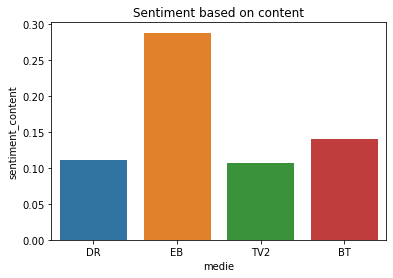

In [33]:
sns.barplot(x="medie", y='sentiment_content', data=article_df, ci=None, estimator=np.mean)
plt.title('Sentiment based on content')
plt.show()

Interestingly, I would have thought Ekstrabladet to have the most negative sentiment in content. However, EB is by far the most positive.

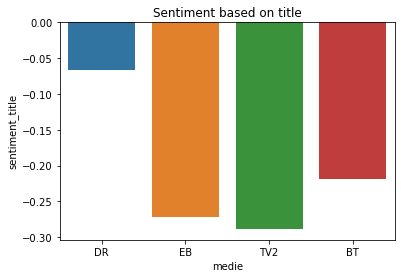

In [34]:
sns.barplot(x="medie", y='sentiment_title', data=article_df, ci=None, estimator=np.mean)
plt.title('Sentiment based on title')
plt.show()

If instead we look at titles or headlines, TV2 and EB is the most negative.  
In general, titles have negative sentiment, whereas content is positive. I suspect this is caused by at least two things:  
1) Titles in general have to provoke abit more.
2) The SENTIDA sentiment model is slightly skewed towards positive words, which may be most pronounced when the analyzed text is longer.

**Sentiment by entity**

In [35]:
# Find top entities by sentiment with count threshold
def find_top(df,count,top):
    return df[df['count'] > count].sort_values(by='average_sentiment',ascending=False)[:top]

In [36]:
# Find bottom entities by sentiment with count threshold
def find_bottom(df,count,bottom):
    return df[df['count'] > count].sort_values(by='average_sentiment')[:bottom]    

In [37]:
find_top(entities_df,10,20)[['entity','average_sentiment']]

,entity,average_sentiment
2091,champions,0.652470
2041,league,0.632773
1997,vm,0.606357
1991,rune,0.602243
1913,danskeren,0.579228
1908,holger,0.577154
1885,danmarks,0.557609
1882,qatar,0.557283
1879,michel,0.555402
1844,french,0.552569


The most positive entities seem to be related to football, Lars Løkke, Socialdemokratiet and of course Denmark (which may actually also be related to football).

In [38]:
find_bottom(entities_df,10,20)[['entity','average_sentiment']][['entity','average_sentiment']]

,entity,average_sentiment
171,texas,-0.413199
259,uvalde,-0.312989
350,robb,-0.284058
349,elementary,-0.284058
426,uvalde,-0.281515
433,texas,-0.269835
414,uvalde,-0.250176
354,politi,-0.248953
561,politi,-0.188335
604,texas,-0.187886


The most negative entities relate to police, crime, shootings and Russia, which is unsurprising.

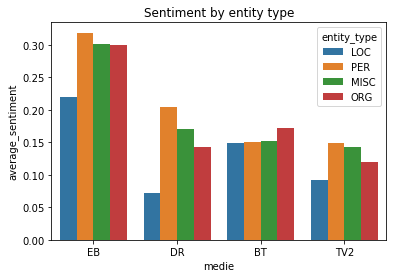

In [39]:
sns.barplot(x='medie', y='average_sentiment', data=entities_df, hue='entity_type', ci=None, estimator=np.mean,orient='v')
plt.title('Sentiment by entity type')
plt.show()

Locations seem to get lower sentiment, whereas persons generally get higher sentiment.

**Sentiment by category**

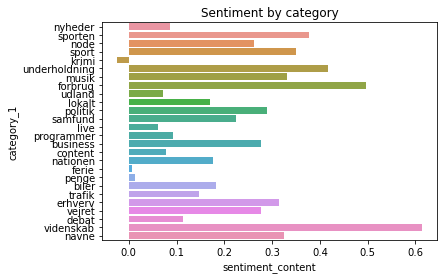

In [40]:
sns.barplot(x='sentiment_content', y='category_1', data=article_df, ci=None, estimator=np.mean,orient='h')
plt.title('Sentiment by category')
plt.show()

The most positive categories are "videnskab","forbrug" and "underholdning". The most negative are "krimi", "ferie", "penge". Bye, bye summer holiday.

### Various preliminary "common sense" tests

**Testing Sentida**

In [41]:
get_sentiment('Jeg er sulten')

-2.55555555555556

In [42]:
get_sentiment('Jeg er mæt')

1.0

**Testing spaCy**

In [43]:
doc = nlp("Jeg hedder Lars. Skal vi spise på McDonald's eller Christiansborg?")

In [44]:
spacy.displacy.render(doc, style="ent")

In [45]:
spacy.displacy.render(doc, style="dep")

In [46]:
for token in doc:
    print(token.lemma_)

Jeg
hedde
Lars
.
Skal
vi
spise
på
McDonald's
eller
Christiansborg
?


**Testing sentiment on various known texts for baseline**

Mr. Beans julekrybben

In [47]:
#https://blog.cbs.dk/mrbean-korpus/?page_id=35#Danske%20skriftlige%20tekster

In [48]:
mr_bean = 'Det uddrag vi blev forevist, begynder med en scene der foregår i et supermarked. Miljøet er et stort rum der er udsmykket med julerelekvier, f.eks. julehjerter,pyntegran. I\
3   bagggrunden hører man musik der ville være typisk for et indkøbcenter i juletiden (julemusik\
4   omsat til muszak). Op¬mærksomheden samles om en mandsfigur der kommer listende ind i billedet\
5   fra baggrunden. Som mands-personen bevæger sig fremad zoomer kameraet ud og i forgrunden\
6   fremkommer et krybbespil, dvs. figurer der forestiller jesusbarnets fødsel i laden ved Bethlehem.\
7   Kameraet zoomer ud således at kun krybbespillet og mandspersonens, der nu står ummiddelbart\
8   bag krybbespillet, hænder er synlige. Manden begynder at lege med figurerne. I begyndelsen er\
9   legen at en figur “laver en lyd”, hvor mandspersonen selv bevæger figuren og frembringer lyden.\
10  En anden figur,også styret af mandspersonen, kommer hen og “tysser” på den første figur. Denne\
11  leg bliver skabt i flere kombinationer, f.eks. hvor en af de tre vise mænd, der er en del af\
12  krybbespillet, “synger” en sang, bliver han standset af de to andre. Legens hovedformål er dog i\
13  hele denne fase at fremstille larmen og de reaktioner den fremkalder.\
14           Efter den\
første fase, hvor forstyrrelsen fremkommer fra en kilde indefra laden,\
bevæger\
15  legen sig over i en fase hvor forstyrrelsen frem¬kommer fra en ekstern kilde. Den første scene\
16  indledes med at mands¬personen nynner en et stykke militærmusik, fra højre fremkommer nu et\
17  stykke legetøj der forestiller et militærorkester. Reaktionen er nu ikke tyssen, men en af dukkerne i\
18  krybbespillet trænder frem og lader militæror¬kesteret defilere forbi, som havde denne figur været\
19  orkesterets øverst¬kommanderen¬de. Efter orkesterets sortie fremkommer nu først et får derefter\
20  flere får, hvor mands personen laver “fårelyde” (bræger som et får). Fra venstre frem¬kommer nu\
21  en legetøjs lastbil, der bakker op til fårene.\
22  Fra højre fremkommer en legetøjs fårehund og fra venstre en fårehyrde. De driver i forening\
23  fårene op i lastbilen, der forsvinder ud til venstre. Fra venstre fører personen en legetøjs dinosauro\
24  ind i krybbespillet. Personen lader dinosauroen true jesusfiguren, der ligger i en krybbe.\
25  Kameraet zoomer ud og personen fører en legetøjs helikopter med en legetøjsfigur, der forestiller\
26  helligåndnen, hængende under sig. Gennem et hul i loftet sænkes helligånddsfigureren og ved\
27  hjælp af en magnet medtages jesusfiguren.\
28           Dette\
bringer historien over i den tredie fase. Efter undsættelsen bringes\
jesusfiguren\
29  over i et andet miljø. Fra det rustikke lademiljø over til et dagligstuemiljø, stadigvæk som legetøj.\
30\
Ummiddelbart herefter opstår historiens klimaks. Man hører en højlydt\
rømmen,\
31  hvorefter kameraet zoomer ud og man ser nu to mands¬personer, hvoraf den ene er den tidligere\
32  præsenterede. Den anden står til venstre for denne og kigger bebrejende på den første.'

In [49]:
get_sentiment(mr_bean)

0.2061218584656083

Peters jul - vers 1-2

In [50]:
peters_jul = "Jeg glæder mig i denne Tid\
nu falder Julesneen hvid,\
og så må julen komme!\
Min Far hver Dag i Byen går,\
og når han kommer hjem, jeg står\
og ser hans store lomme.\
\
Og paa hans bord forleden dag\
jeg så et yndigt, lille Flag,\
og det jeg ikke glemmer.\
Papir han klipper med en Saks;\
men naar jeg kommer ind, han straks\
sin Stads i Skuffen gemmer."

In [51]:
get_sentiment(peters_jul)

0.10687771323529377

Den lille pige med svovlstikkerne

In [52]:
with open(r'D:\Datasets\svovlstikkerne.txt', 'r',encoding='utf-8') as f:
    svovlstikkerne = f.readlines()
f.close()

In [53]:
get_sentiment(str(svovlstikkerne))

0.5680735913980035

I must admit I did not expect the most positive sentiment for the last text.